## Final Project
### Nicolas Longuet Marx

This document shows the output provided by the package. 

In [150]:
import os
import numpy as np
import pandas as pd
import requests
import json
import codecs
import matplotlib.pyplot as plt
from legcop import LegiScan
import nltk 
import base64
from bs4 import BeautifulSoup
from collections import Counter
from matplotlib.ticker import FormatStrFormatter
import re


In [2]:
api_key = "ENTER KEY HERE"
legis = LegiScan(api_key)

In [30]:
### create text documents
def import_text(num, path):
    mylink2="https://api.legiscan.com/?key="+api_key+"&op=getBillText&id="+num
    r = requests.get(mylink2)
    json_response=r.json()
    json_response
    mydataframe=pd.DataFrame(json_response)
    mynew=mydataframe['text']
    mynew.to_frame()
    base64_message = mynew['doc']
    mydecoded = base64.b64decode(base64_message)
    html = mydecoded
    soup = BeautifulSoup(html, features="html.parser")
    #base64_bytes = base64_message.encode('ascii')
    #message_bytes = base64.b64decode(base64_bytes)
    #message = message_bytes.decode('ascii')
    raw = soup.get_text()  
    output_file = open(path+'\Output_'+num+'.txt', 'w', encoding="utf-8")
    output_file.write(raw)
    output_file.close()


In [252]:
import_text('1138632', 'NY')

In [343]:
# get the list of datasets available
def get_session_list(state):
    mylink2='https://api.legiscan.com/?key='+api_key+'&op=getDatasetList&state='+state
    r = requests.get(mylink2)
    json_response=r.json()
    json_response
    global mylist
    mylist=pd.DataFrame.from_dict(json_response['datasetlist'])
    #print(mylist)

    


In [344]:
get_session_list('NY')


In [345]:
mylist

,state_id,session_id,special,year_start,year_end,session_name,session_title,dataset_hash,dataset_date,dataset_size,access_key,push_safe
0,32,1644,0,2019,2020,2019-2020 General Assembly,General Assembly,113b58315ac9dbb2a50bf213f974b18e,2020-12-13,43909253,6FfiSKPtMWk6vO9OcFX0nW,0
1,32,1420,0,2017,2018,2017-2018 General Assembly,General Assembly,59b37327906aa03802629fd4f8161684,2020-08-04,39326806,3L9swKqrRNug3Hi0JMPGSQ,1
2,32,1143,0,2015,2016,2015-2016 General Assembly,General Assembly,1dbc5194aebd7fd04542fd580a0fad8c,2020-08-04,29804887,343NswGFEQhS5ZlfFb6Pn6,1
3,32,1013,0,2013,2014,2013-2014 General Assembly,General Assembly,b960085f29d963a51ec91ddfeab7941c,2020-08-04,30070817,7GfUXxyg2p3P8dOmdCkkXY,1
4,32,93,0,2011,2012,2011-2012 General Assembly,General Assembly,d4571c38555e97b192156afe16c0fc33,2020-08-04,31805251,2Qr7tfPpjyZUf4I8tps8mI,1
5,32,27,0,2009,2010,2009 General Assembly,General Assembly,ef9c2286d2c6f578500c56eb84feede9,2020-08-04,21773860,18pIeYkWCUjLQEpwpc1CBY,1


In [346]:
# get the list of bills
def get_bill_list(session_num):
    mylink2="https://api.legiscan.com/?key="+api_key+"&op=getMasterList&id="+session_num
    r = requests.get(mylink2)
    json_response=r.json()
    mydata=pd.DataFrame.from_dict(json_response['masterlist'])
    mynewdata=mydata.loc[  'title' ,:]
    global mytitlelist
    mytitlelist=mynewdata.to_frame()
    mytitlelist=mytitlelist.dropna(subset=['title'])
    session_id=mydata.loc['session_id', 'session']
    session_name=mydata.loc['session_name', 'session']
    mydata.loc['session_id', :]=session_id
    mydata.loc['session_name', :]=session_name
    global mydatanew
    mydatanew=mydata.transpose()
    mydatanew=mydatanew.drop(['session'])
    mydatanew=mydatanew.dropna(subset=['title'])
    #print(mytitlelist)

In [347]:
get_bill_list('27')


In [348]:
mytitlelist

,title
0,"Upon the request of a municipality, farm owner..."
1,Relates to the employment of school nurses for...
2,"Enacts the ""New York state YouthBuild act""; cr..."
3,Requires the furnishing of programs and servic...
4,Requires consideration of evidence relating to...
...,...
13105,Enacts into law major components of legislatio...
13106,"Amends provisions of the education, labor and ..."
13107,Establishes a special commission on judicial c...
13108,Updates the state energy conservation construc...


In [176]:
mydico = {
    "environment" : ".environment|energy|tree|river|forest|animal|insect|fertilizer|dam|agricult|water|land|water|owner|control|site|air|solid|gas|tenant|oil|park|airport|coal|plant|prevent|underground|power|soil|portion|landlord|condition.",
    "courts" : ".court|judgment|attorney|case|appeal|civil|petition|sheriff|trial|circuit court|district court|such_person|complaint|counsel|brought|circuit|warrant|paid",
    "pensions": ".paid|benefit|rate|payment|equal|death|age|credit|pay|total|life|pension|premium|calendar year|loss|account|case|per cent|event|membership|excess|maximum.",
    "local_projects": ".development|local|project|budget|government|cost|grant|research|center|local government|data|transfer|governor|is the intent|develop|urban|review|biennium.",
    "procurement":".director|contract|work|review|civil|labor|contractor|attorney general|bureau|final|perform|audit|receipt|status|exempt|panel|government|firm|bid|prepared.",
    "elections":".district|town|petition|charter|special|ballot|mayor|voter|township|precinct|cast|referendum|census|elector|case|town council|said district|such district.",
    "banking":".loan|trust|bank|agent|partnership|institution|foreign|stock|mortgage|deposit|surplus|interest|merger|credit union|partner|case|credit|gift|branch|transact.",
    "licensing":".license|fee|dealer|sale|food|sold|holder|sell|valid|fish|agent|distributor|milk|liquor|product|such license|livestock|game|card|retail|misdemeanor|fine.",
    "real_estate":".real|interest|sale|owner|contract|claim|lien|payment|transfer|instrument|seller|holder|issuer|debtor|claimant|buyer|pay|broker|settlement|receipt|money.",
    "bonds":".interest|bond|payment|commonwealth|cost|sale|paid|pay|project|power|thereon|sold|debt|pledge|local law|event|hereof|proper|said board|real|port|sell|therefrom.",
    "expenditures":".fund|account|money|paid|special|pay|tile|payment|transfer|for the fiscal year|excess|trust fund|so much thereof|deposit|state general fund|auditor|tie.",
    "bureaucracy":".governor|council|government|chief|fire|appoint|personnel|compact|conflict|perform|shall consist|invalid|parish|successor|volunteer|membership|head|travel.",
    "healthcare":".health|care|treatment|health care|physician|home|human|patient|mental|mental health|drug|social|condition|public health|medicaid|dental|client|review|institution.",
    "child_custody":".child|court|minor|children|parent|age|probation|crime|victim|parole|guardian|adult|petition|placement|youth|case|social|legal|child support|obligor|home.",
    "taxes":".tax|paid|gross|credit|return|net|rate|exempt|assessor|case|refund|equal|sale|total|calendar year|payment|fuel|portion|sold|price|retail|zone|pay|such tax.",
    "education":".school|school district|state board|district|student|institution|higher|teacher|special|aid|pupil|children|school year|tuition|high school|school board.",
    "traffic1":".motor|highway|driver|owner|traffic|plate|test|vessel|accident|weight|special|sect|trailer|railroad|state highway|stricken|feet|fine|alcohol|aircraft|carrier.",
    "traffic2":".street|road|feet|island|river|run|tract|team|great|highway|township|cent."
    }
type_to_id = {key : value for key,value in enumerate(mydico.keys())}


In [335]:
# regex classifcation
def classification(data):
    i=0
    for key, value in mydico.items():
        data.loc[data.title.str.contains(value), 'type']=key
        i=i+1
        data.loc[data.title.str.contains(value), 'typenum']=i
#mylistofcat=[ environment_list,courts_list , pensions_list,local_projects_list,elections_list, banking_list, licensing_list, real_estate_list, bonds_list, expenditures_list 
    # graph de classification
    fig, ax = plt.subplots()
    label=mydico.keys()
    counts, mybins, patches = ax.hist(data.typenum, facecolor='red', edgecolor='gray' , bins=17)
    # Set the ticks to be at the edges of the bins.
    ax = plt.hist(mybins, bins=17)
    plt.xticks(mybins , mydico.keys(), rotation='vertical')
    plt.title('Number of laws per categories')
    plt.show()

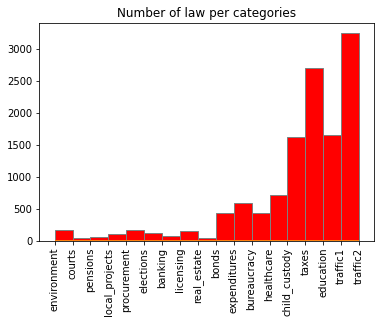

In [195]:
classification(mytitlelist)

In [299]:
# get_session_list('NY')
mylist[mylist.year_start==int(myyear)]  


,state_id,session_id,special,year_start,year_end,session_name,session_title,dataset_hash,dataset_date,dataset_size,access_key,push_safe
5,32,27,0,2009,2010,2009 General Assembly,General Assembly,ef9c2286d2c6f578500c56eb84feede9,2020-08-04,21773860,18pIeYkWCUjLQEpwpc1CBY,1


In [336]:
def overall_request(state, download=False,  **kwargs):
    #kwargs are here year and path
    #here I would like to put something like: if year is not specified
    get_session_list(state)
    #myyear=kwargs['year']
    if 'year' in kwargs:
        if (type(kwargs['year'])==int):
            myyear=str(kwargs['year'])
        if re.search(r'\d\d\d\d', myyear):
            global mylist
            mylist=mylist[mylist.year_start==int(myyear)]         
    mysessionlist=mylist['session_id']
    for i in mysessionlist:
        if (type(i)== int):
            i=str(i)
        get_bill_list(i)
        if download == True:
            print('hello')
            for j in mydatanew.bill_id: 
                if (type(j)==int):
                    j=str(j)
                import_text(j, kwargs['path'])
                
    classification(mytitlelist)
        
    
    

In [301]:
overall_request('NY', download=True, year=2009,  path="NY")

2009
   state_id  session_id  special  year_start  year_end           session_name  \
5        32          27        0        2009      2010  2009 General Assembly   

      session_title                      dataset_hash dataset_date  \
5  General Assembly  ef9c2286d2c6f578500c56eb84feede9   2020-08-04   

   dataset_size              access_key  push_safe  
5      21773860  18pIeYkWCUjLQEpwpc1CBY          1  
27
hello
212253


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212254
212255
212256


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212257
212258
212259


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212260
212261
212262
212263
212264
212265
212266
212267
212268
212269
212270


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212271
212272
212273


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212274
212275


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212276


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212277
212278
212279


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212280
212281
212282


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212283


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212284


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212285
212286
212287
212288
212289
212290
212291


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212292
212293
212294
212295
212296
212297
212298
212299


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212300


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212301
212302
212303


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212304
212305
212306
212307


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212308
212309
212310
212311


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212312
212313


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212314


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212315
212316
212317
212318


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212319
212320
212321
212322


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212323
212324


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212325
212326
212327
212328


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212329
212330
212331
212332


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212333
212334
212335
212336


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212337
212338
212339
212340
212341


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212342
46639
212343
46640


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46641


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46642


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46643


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46644
46645
212344
46646
46647
212345


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212346
46648
57068
57069
57070
46649
212347
46650
212348


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212349
212350
57071
212351


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46651
46652
46653
46654


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46655


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46656


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46657


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


57072
46658


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212352
46659
46660
46661
46662
46663
57073
46664
212353
46665
46666


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46667
212354
46668
212355
212356
46669
46670
46671
46672
212357
212358
212359
212360


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46673
212361
212362


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46674


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46675
212363
46676
212364
46677


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46678


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212365
212366


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46679


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212367
46680


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46681
46682
212368
46683
46684


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46685


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46686


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46687


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46688
46689
46690
46691
46692
46693
46694
46695


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212369
212370
212371
46696
46697
212372
212373


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46698
46699
46700
46701
46702
46703
212374
212375


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46704


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46705


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46706
46707
46708
212376
46709
46710
46711
212377


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46712
46713
46714


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212378
46715


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46716
46717
46718
46719


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212379
46720


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212380
46721


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212381
46722


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212382


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46723


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46724
46725
212383
46726


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212384
46727


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46728
46729
46730
46731
46732
46733
212385
46734
212386


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46735
212387
46736


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212388
46737
46738
212389
46739
46740
46741
46742
46743
46744
46745


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46746
212390
46747
46748
57074
57075
46749
46750
46751
46752
46753
46754


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46755


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46756
46757
212391
46758
46759
46760


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46761


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46762


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212392
212393
212394


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46763
46764
46765


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212395


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46766


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46767
46768
46769
57076
212396
46770
46771
46772
46773


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46774


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212397
46775


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46776


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46777
46778
212398
46779
46780
46781
46782
46783


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46784
46785
46786
57077
46787
46788
46789


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46790
46791
46792
46793
46794
46795
46796
46797


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46798
212399
46799


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46800
46801
212400
46802
46803


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46804
212401
46805
212402


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46806
212403
46807
212404


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212405
212406
212407


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212408
46808
46809
46810
46811


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46812


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46813


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212409


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46814
46815
46816
212410
46817
212411


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46818
46819
46820
212412
212413
46821


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46822


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46823
46824
46825
46826
212414


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212415
212416


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212417
46827
212418
212419
46828
46829
46830


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212420
46831
46832
46833
212421
46834
46835


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46836
46837
46838
212422


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46839


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


46840
46841
212423
46842
46843
46844
46845
212424


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212425
46846
212426
46847


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


212427


KeyError: 'text'

2019
   state_id  session_id  special  year_start  year_end  \
0        32        1644        0        2019      2020   

                 session_name     session_title  \
0  2019-2020 General Assembly  General Assembly   

                       dataset_hash dataset_date  dataset_size  \
0  113b58315ac9dbb2a50bf213f974b18e   2020-12-13      43909253   

               access_key  push_safe  
0  6FfiSKPtMWk6vO9OcFX0nW          0  
1644


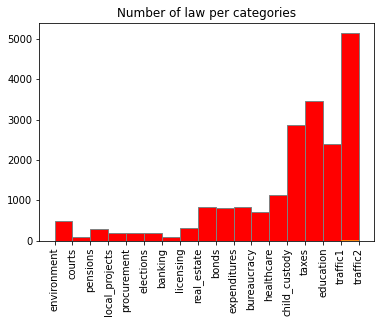

In [305]:
overall_request('NY', year=2019)

title      2375
type       2375
typenum    2375
dtype: int64

# TEST PART

In [341]:
import pytest
# I want to make sure my function returns the same output as what I would get from the direct command:
def test_package():
    mylink2="https://api.legiscan.com/?key="+api_key+"&op=getMasterList&id=1644"
    r = requests.get(mylink2)
    json_response=r.json()
    mydata=pd.DataFrame.from_dict(json_response['masterlist'])
    mynewdata=mydata.loc[  'title' ,:]
    mytitlelist=mynewdata.to_frame()
    mytitlelist=mytitlelist.dropna(subset=['title'])
    mydico = {
    "environment" : ".environment|energy|tree|river|forest|animal|insect|fertilizer|dam|agricult|water|land|water|owner|control|site|air|solid|gas|tenant|oil|park|airport|coal|plant|prevent|underground|power|soil|portion|landlord|condition.",
    "courts" : ".court|judgment|attorney|case|appeal|civil|petition|sheriff|trial|circuit court|district court|such_person|complaint|counsel|brought|circuit|warrant|paid",
    "pensions": ".paid|benefit|rate|payment|equal|death|age|credit|pay|total|life|pension|premium|calendar year|loss|account|case|per cent|event|membership|excess|maximum.",
    "local_projects": ".development|local|project|budget|government|cost|grant|research|center|local government|data|transfer|governor|is the intent|develop|urban|review|biennium.",
    "procurement":".director|contract|work|review|civil|labor|contractor|attorney general|bureau|final|perform|audit|receipt|status|exempt|panel|government|firm|bid|prepared.",
    "elections":".district|town|petition|charter|special|ballot|mayor|voter|township|precinct|cast|referendum|census|elector|case|town council|said district|such district.",
    "banking":".loan|trust|bank|agent|partnership|institution|foreign|stock|mortgage|deposit|surplus|interest|merger|credit union|partner|case|credit|gift|branch|transact.",
    "licensing":".license|fee|dealer|sale|food|sold|holder|sell|valid|fish|agent|distributor|milk|liquor|product|such license|livestock|game|card|retail|misdemeanor|fine.",
    "real_estate":".real|interest|sale|owner|contract|claim|lien|payment|transfer|instrument|seller|holder|issuer|debtor|claimant|buyer|pay|broker|settlement|receipt|money.",
    "bonds":".interest|bond|payment|commonwealth|cost|sale|paid|pay|project|power|thereon|sold|debt|pledge|local law|event|hereof|proper|said board|real|port|sell|therefrom.",
    "expenditures":".fund|account|money|paid|special|pay|tile|payment|transfer|for the fiscal year|excess|trust fund|so much thereof|deposit|state general fund|auditor|tie.",
    "bureaucracy":".governor|council|government|chief|fire|appoint|personnel|compact|conflict|perform|shall consist|invalid|parish|successor|volunteer|membership|head|travel.",
    "healthcare":".health|care|treatment|health care|physician|home|human|patient|mental|mental health|drug|social|condition|public health|medicaid|dental|client|review|institution.",
    "child_custody":".child|court|minor|children|parent|age|probation|crime|victim|parole|guardian|adult|petition|placement|youth|case|social|legal|child support|obligor|home.",
    "taxes":".tax|paid|gross|credit|return|net|rate|exempt|assessor|case|refund|equal|sale|total|calendar year|payment|fuel|portion|sold|price|retail|zone|pay|such tax.",
    "education":".school|school district|state board|district|student|institution|higher|teacher|special|aid|pupil|children|school year|tuition|high school|school board.",
    "traffic1":".motor|highway|driver|owner|traffic|plate|test|vessel|accident|weight|special|sect|trailer|railroad|state highway|stricken|feet|fine|alcohol|aircraft|carrier.",
    "traffic2":".street|road|feet|island|river|run|tract|team|great|highway|township|cent."
    }
    type_to_id = {key : value for key,value in enumerate(mydico.keys())}
    i=0
    for key, value in mydico.items():
        mytitlelist.loc[mytitlelist.title.str.contains(value), 'type']=key
        i=i+1
        mytitlelist.loc[mytitlelist.title.str.contains(value), 'typenum']=i
    expected=mytitlelist[mytitlelist.typenum==18.0].count()
    expected=expected['title']
    overall_request('NY', year=2019)
    predicted=mytitlelist[mytitlelist.typenum==18.0].count()
    predicted=predicted['title']
    assert predicted == expected 

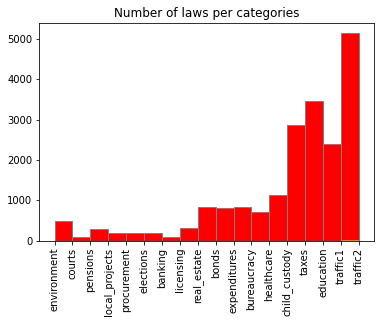

2375
2375


In [342]:
test_package()